## 1. Implement a feedforward neural network and write the backpropagation code for training the network from scratch. Use numpy for all matrix/vector operations. You are not allowed to use any automatic differentiation packages. This network will be trained and tested using the Fashion-MNIST dataset. Specifically, given an input image (28 x 28 = 784 pixels) from the Fashion-MNIST dataset, the network will be trained to classify the image into 1 of 10 classes.

a) Download the fashion-MNIST dataset and plot 1 sample image for each class in a grid.

In [ ]:
!pip install torchvision --q
!pip install transforms --q
!pip install sgmllib3k --q

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import heapq
%matplotlib inline

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
# train/test_set is of type dataset (like a tuple). elements can be accessed as train_set[i], will be of len 2
print(type(train_set))
print(len(train_set))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000


In [ ]:
# Create data loaders that will load data.
# train/test_loader is of type DataLoader that contains features(X) (tensor[N, C(=1), H, W]) and labels(y) (tensor[N])
train_loader = DataLoader(train_set, batch_size=len(train_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

# dim of train_dataset = (N(batches), C(channels), H, W). element can be accessed as X[i], will be of len (1, 28, 28)
train_features = next(iter(train_loader))[0].numpy().squeeze(1)
test_features = next(iter(test_loader))[0].numpy().squeeze(1)
train_labels = next(iter(train_loader))[1].numpy()
test_labels = next(iter(test_loader))[1].numpy()

In [ ]:
print("Type of dataset:", type(train_features))
print(f"Shape of features (N, H, W): {train_features.shape}")
print(f"Shape of labels: {train_labels.shape}")

Type of dataset: <class 'numpy.ndarray'>
Shape of features (N, H, W): (60000, 28, 28)
Shape of labels: (60000,)


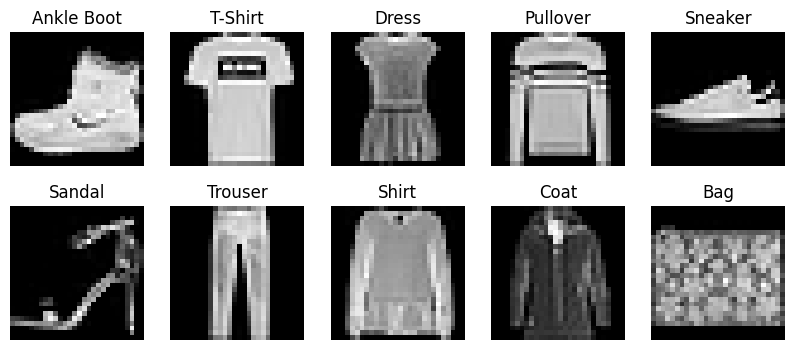

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(10, 4))
rows, cols = 2, 5
selected_img = {}

for i in range(len(train_labels)):
    label = train_labels[i]
    if label not in selected_img:
      selected_img[label] = i
    if len(selected_img) == 10:
      break

for i, (label, img_id) in enumerate(selected_img.items(), 1):
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(train_features[img_id].squeeze(), cmap="gray")
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

b) Implement a feedforward neural network using Numpy which takes images from the fashion-MNIST data as input and outputs a probability distribution over the 10 classes. Use only one hidden layer.

c) Implement from scratch the backpropagation algorithm with support for the following optimization functions — sgd, momentum based gradient descent.

In [ ]:
def ReLU(x):
    return np.maximum(0, x)

In [ ]:
class OneHiddenLayerNet(object):
    """
    A one-hidden-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C(10) classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init="random"):
        """
        Initialize the model. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data = 28x28.
        - hidden_size: The number of neurons H in the hidden layer = 64, 128.
        - output_size: The number of classes C = 10.

        Weight initialization (weight_init): random or Xavier
        - random: Weights are initialized to small random values and biases are initialized to zero.
        - Xavier - weight = Uniform [-(1/sqrt(n)), 1/sqrt(n)] where n = no. of inputs to node
        """
        self.params = {}

        if weight_init == "random":
            self.params['W1'] = np.random.randn(input_size, hidden_size) * 0.01
            self.params['b1'] = np.zeros((1, hidden_size))
            self.params['W2'] = np.random.randn(hidden_size, output_size) * 0.01
            self.params['b2'] = np.zeros((1, output_size))

        elif weight_init == "xavier":
            lower, upper = -(1.0 / np.sqrt(input_size)), (1.0 / np.sqrt(input_size))
            self.params['W1'] = np.random.uniform(lower, upper, (input_size, hidden_size))
            self.params['b1'] = np.zeros((1, hidden_size))
            lower, upper = -(1.0 / np.sqrt(hidden_size)), (1.0 / np.sqrt(hidden_size))
            self.params['W2'] = np.random.uniform(lower, upper, (hidden_size, output_size))
            self.params['b2'] = np.zeros((1, output_size))

    def loss(self, X, y=None, reg=0.5):
        """
        Compute the loss and gradients (using backprop) for a one-hidden layer
        fully connected neural network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength/weight decay (L2 regularisation).

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)  # (N, H)
        out = np.dot(h1, W2) + b2      # (N, C)
        scores = out

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Computing softmax
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1). axis = 1 means that since result is along y-axis, collapse/find max along x-axis/each row
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)

        # Compute the loss
        correct_logprobs = -np.log(probs[range(N), y])        # (N,1), for all rows, select that row's prob for target y and compute negative log likelihood
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss

        # Backward pass: compute gradients understand later
        grads = {}
        dscores = probs                                 # (N,C)
        dscores[range(N), y] -= 1
        dscores /= N
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        dW2 += reg * W2
        dW1 += reg * W1

        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    def train(self, X, y, X_val, y_val, learning_rate=1e-4, num_epochs=10, batch_size=64,
              optimizer="sgd", reg=0.5, verbose=False):
        """
        Train this neural network using stochastic gradient descent/momentum based gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)

        # Use SGD to optimize the parameters in self.model
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(1, num_epochs * iterations_per_epoch + 1):
            X_batch = None
            y_batch = None

            # Create a random minibatch of training data and labels. batch_size = 1 for sgd, 64 for mini-batch mu-based gd
            sample_index = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[sample_index, :]
            y_batch = y[sample_index]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            if optimizer == "sgd": # Vanilla SGD update rule
              self.params['W2'] -= learning_rate * grads['W2']
              self.params['b2'] -= learning_rate * grads['b2']
              self.params['W1'] -= learning_rate * grads['W1']
              self.params['b1'] -= learning_rate * grads['b1']

            elif optimizer == "momentum": # Momentum-based SGD update rule
                mu = 0.85
                v_W2 = mu * v_W2 - learning_rate * grads['W2']
                self.params['W2'] += v_W2
                v_b2 = mu * v_b2 - learning_rate * grads['b2']
                self.params['b2'] += v_b2
                v_W1 = mu * v_W1 - learning_rate * grads['W1']
                self.params['W1'] += v_W1
                v_b1 = mu * v_b1 - learning_rate * grads['b1']
                self.params['b1'] += v_b1

            if verbose and it % iterations_per_epoch == 0:
            # Every epoch, check train and val accuracy
                epoch = it // iterations_per_epoch
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                print(f"Epoch {epoch} / {num_epochs}: loss {loss}, train_acc: {train_acc}, val_acc: {val_acc}")

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this one-hidden-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])
        scores = np.dot(h1, self.params['W2']) + self.params['b2']
        y_pred = np.argmax(scores, axis=1)

        return y_pred

d) Use the standard train/test split of fashionMnist. Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters.

*number of epochs: 10*

*weight decay (L2 regularisation): 0.5*

*batch size: 64*

*learning rate: 1e-4*

*activation functions: ReLU*

*size of hidden layer: 64, 128*

*optimizer: sgd, momentum*

*weight initialisation: random, Xavier*

In [ ]:
n_val = 1000
n_train = train_labels.shape[0] - n_val # 59000
n_test = test_labels.shape[0] # 10000

mask = list(range(n_train, n_train + n_val))
X_val = train_features[mask]           # (1000, 28, 28)
y_val = train_labels[mask]             # (1000,)

mask = list(range(n_train))
X_train = train_features[mask]         # (59000, 28, 28)
y_train = train_labels[mask]           # (59000,)

mask = list(range(n_test))
X_test = test_features[mask]           # (10000, 28, 28)
y_test = test_labels[mask]           # (10000,)

# Reshape data to rows
X_train = X_train.reshape(n_train, -1) # (59000, 784)
X_val = X_val.reshape(n_val, -1)       # (1000, 784)
X_test = X_test.reshape(n_test, -1)    # (10000, 784)

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

# Load FashionMNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# Determine the size of validation set (10% of training)
val_size = int(0.1 * X_train.shape[0])

# Shuffle indices for random selection
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# Split the data
X_val, y_val = X_train[indices[:val_size]], y_train[indices[:val_size]]
X_train, y_train = X_train[indices[val_size:]], y_train[indices[val_size:]]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X_train.shape

(54000, 28, 28)

e) Based on this, report configurations that are giving the top 3 accuracies. For the best model obtained, report the accuracy on the test set of fashionMnist and report the confusion matrix.

In [ ]:
input_size = X_train.shape[1]          # 784
output_size = 10
hidden_sizes = [64, 128]
optimizers = ["sgd", "momentum"]
weight_inits = ["random", "xavier"]

best_val_acc = 0
best_hyperparams = None
results = []

# Loop over all hyperparameter combinations
for hidden_size in hidden_sizes:
  for optimizer in optimizers:
    for weight_init in weight_inits:
        print(f"Training with hidden_size={hidden_size}, optimizer={optimizer}, weight_init={weight_init}")

        # Initialize the model with current hyperparameters
        nn = OneHiddenLayerNet(input_size, hidden_size, output_size, weight_init)

        # Train the model
        stats = nn.train(X_train, y_train, X_val, y_val, learning_rate=1e-4, num_epochs=10, batch_size=64, optimizer=optimizer, reg=1e-4, verbose=False)

        # Predict on the validation set
        val_acc = (nn.predict(X_val) == y_val).mean()

        # Store the results
        results.append({
                    "hidden_size": hidden_size,
                    "optimizer": optimizer,
                    "weight_init": weight_init,
                    "val_acc": val_acc
                })

top_3_results = heapq.nlargest(3, results, key=lambda x: x["val_acc"])

# Print the top 3 hyperparameter combinations
print("\nTop 3 Hyperparameter Combinations:")
for i, res in enumerate(top_3_results, 1):
    print(f"Rank {i}: {res}")

Training with hidden_size=64, optimizer=sgd, weight_init=random
Training with hidden_size=64, optimizer=sgd, weight_init=xavier
Training with hidden_size=64, optimizer=momentum, weight_init=random
Training with hidden_size=64, optimizer=momentum, weight_init=xavier
Training with hidden_size=128, optimizer=sgd, weight_init=random
Training with hidden_size=128, optimizer=sgd, weight_init=xavier
Training with hidden_size=128, optimizer=momentum, weight_init=random
Training with hidden_size=128, optimizer=momentum, weight_init=xavier

Top 3 Hyperparameter Combinations:
Rank 1: {'hidden_size': 128, 'optimizer': 'momentum', 'weight_init': 'xavier', 'val_acc': 0.715}
Rank 2: {'hidden_size': 64, 'optimizer': 'momentum', 'weight_init': 'xavier', 'val_acc': 0.693}
Rank 3: {'hidden_size': 128, 'optimizer': 'momentum', 'weight_init': 'random', 'val_acc': 0.638}


In [ ]:
# Initialize the model with best hyperparameters
nn = OneHiddenLayerNet(input_size, 128, output_size, weight_init="xavier")

# Train the model
stats = nn.train(X_train, y_train, X_val, y_val, learning_rate=1e-4, num_epochs=10, batch_size=64, optimizer="momentum", reg=1e-4, verbose=True)

# Predict on the test set
y_pred = nn.predict(X_test)
test_acc = (y_pred == y_test).mean()

Epoch 1 / 10: loss 2.0728635921718754, train_acc: 0.5, val_acc: 0.577
Epoch 2 / 10: loss 1.7907184917301113, train_acc: 0.59375, val_acc: 0.615
Epoch 3 / 10: loss 1.477504648176362, train_acc: 0.703125, val_acc: 0.644
Epoch 4 / 10: loss 1.35821648187728, train_acc: 0.671875, val_acc: 0.649
Epoch 5 / 10: loss 1.2701535329503608, train_acc: 0.609375, val_acc: 0.655
Epoch 6 / 10: loss 1.1009803598325294, train_acc: 0.6875, val_acc: 0.669
Epoch 7 / 10: loss 0.9681318183911539, train_acc: 0.703125, val_acc: 0.67
Epoch 8 / 10: loss 1.0070074841461618, train_acc: 0.65625, val_acc: 0.684
Epoch 9 / 10: loss 0.7827350816330564, train_acc: 0.734375, val_acc: 0.685
Epoch 10 / 10: loss 0.9266147900252247, train_acc: 0.640625, val_acc: 0.695


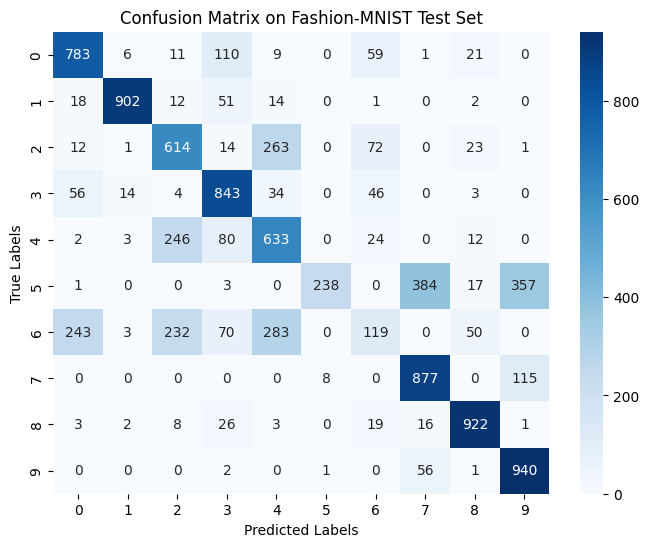

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = nn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix on Fashion-MNIST Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 2) Consider the following function: $$ f(x) = \frac{1 + \tanh((wx + b)/2)}{2}. $$ Here, $x$ is the input, and $w, b$ are parameters. Also, we are given the definition of the hyperbolic tangent function: $$ \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}. $$ The loss function is defined as: $$ L((x,y)) = \frac{(y - f(x))^2}{2}. $$ Find the gradients: $$ \frac{\partial L}{\partial w} \quad \text{and} \quad \frac{\partial L}{\partial b}. $$


Using the chain rule:  

$$ \frac{\partial L}{\partial f} = \frac{\partial}{\partial f} \left( \frac{(y - f(x))^2}{2} \right) $$

Applying differentiation:  

$$ \frac{\partial L}{\partial f} = -(y - f(x)) $$  

Since  

$$ f(x) = \frac{1 + \tanh((wx + b)/2)}{2}, $$  

differentiating with respect to $ w $:  

$$ \frac{\partial f}{\partial w} = \frac{1}{2} \cdot \left( 1 - \tanh^2((wx + b)/2) \right) \cdot \frac{x}{2} $$  

Thus,  

$$ \frac{\partial f}{\partial w} = \frac{x}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  

Similarly, differentiating with respect to $ b $:  

$$ \frac{\partial f}{\partial b} = \frac{1}{2} \cdot \left( 1 - \tanh^2((wx + b)/2) \right) \cdot \frac{1}{2} $$  

So,  

$$ \frac{\partial f}{\partial b} = \frac{1}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  

Using the chain rule:  

$$ \frac{\partial L}{\partial w} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial w} $$  

Substituting values:  

$$ \frac{\partial L}{\partial w} = -(y - f(x)) \cdot \frac{x}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  

Similarly,  

$$ \frac{\partial L}{\partial b} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial b} $$  

Substituting values:  

$$ \frac{\partial L}{\partial b} = -(y - f(x)) \cdot \frac{1}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  

Final Answer  

$$ \frac{\partial L}{\partial w} = -(y - f(x)) \cdot \frac{x}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  

$$ \frac{\partial L}{\partial b} = -(y - f(x)) \cdot \frac{1}{4} \left( 1 - \tanh^2((wx + b)/2) \right) $$  


## 3. (Refer to the book “Understanding Deep Learning” https://udlbook.github.io/udlbook/) for the chapter on convolutions. A network consists of three 1D convolutional layers. At each layer, a zero-padded convolution with kernel size seven, stride one, is applied. What size is the receptive field of hidden units in the third layer?


The receptive field of a neuron in a neural network is the number of the original input nodes that feed into it. Consider a CNN where each convolutional layer has kernel size three. The neurons in the first layer take a weighted sum of the three closest inputs, so have receptive fields of size three. The units in the second layer take a weighted sum of the three closest positions in the first layer, which are themselves weighted sums of three inputs. Hence, the hidden units in the second layer have a receptive field of size five (3 + 3-1 or k + k-1).

Therefore, for a network with 3 1D convolutional layers, one neuron in the 3<sup>rd</sup> layer sees 7 neurons in the 2<sup>nd</sup> layer. One neuron in the 2<sup>nd</sup> layer sees 7 neurons in the 1<sup>st</sup> layer. There are 6 other neurons in the 2<sup>nd</sup> layer that see 6 unique neurons in the 1<sup>st</sup> layer. So one neuron in the 3<sup>rd</sup> layer sees 7 + 7-1 = 13 neurons in the 1<sup>st</sup> layer.

Now one neuron in the 1<sup>st</sup> layer sees 7 neurons in the input layer. There are 12 other neurons apart from it in the 1<sup>st</sup> layer connected to the 3<sup>rd</sup> layer. These 12 neurons are connected to 12 unique input nodes in the input layer (due to a stride of 1). So one neuron in 3<sup>rd</sup> layer sees 7 + 12 = 19 neurons in the input layer.

Zero padding doesn't affect receptive field because it is not part of the input.

The size of the receptive field of hidden units in the third layer is **19**.


## 4. Write out the equation for a 1D convolution with kernel size of seven, a dilation rate of three, and a stride of three.

This is 1D convolution with a kernel size of three, stride of one,
and dilation one:
$z_i = \omega_1 x_{i-1} + \omega_2 x_i + \omega_3 x_{i+1}$

For kernel size of seven, a dilation rate of three, and a stride of three, $z_i = \omega_0 x_{i-9} + \omega_1 x_{i-6} + \omega_2 x_{i-3} + \omega_3 x_i + \omega_4 x_{i+3} + \omega_5 x_{i+6} + \omega_6 x_{i+9}$


With a stride of three, we evaluate the kernel skipping 2 positions, so the first output z1 is computed from a weighted sum centered at x1, and the second output z2 is computed from a weighted sum centered at x4 and so on.